# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [2]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%load_ext jupyternotify

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [3]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [4]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats_not_stacked = extract_features(X_train, feature_fns, verbose=True)
X_val_feats_not_stacked = extract_features(X_val, feature_fns)
X_test_feats_not_stacked = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats_not_stacked, axis=0, keepdims=True)
X_train_feats_not_stacked -= mean_feat
X_val_feats_not_stacked -= mean_feat
X_test_feats_not_stacked -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats_not_stacked, axis=0, keepdims=True)
X_train_feats_not_stacked /= std_feat
X_val_feats_not_stacked /= std_feat
X_test_feats_not_stacked /= std_feat

X_train_feats_ns = X_train_feats_not_stacked
X_val_feats_ns = X_val_feats_not_stacked
X_test_feats_ns = X_test_feats_not_stacked

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

In [4]:
from cs231n.features import *

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats_not_stacked, np.ones((X_train_feats_not_stacked.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats_not_stacked, np.ones((X_val_feats_not_stacked.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats_not_stacked, np.ones((X_test_feats_not_stacked.shape[0], 1))])

(49000, 155)


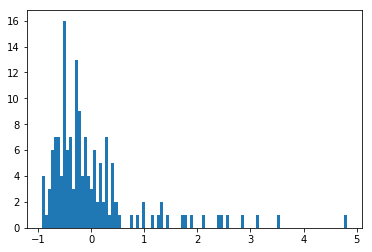

In [70]:
print(X_train_feats.shape)
# print(X_train_feats[:2])

plt.hist(X_train_feats[0], bins=101)
plt.show()

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [8]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
from cs231n.classifiers import LinearSVM

def run_training(learning_rates,
                 regularization_strengths,
                 num_iters=4600
                ):
    # results is dictionary mapping tuples of the form
    # (learning_rate, regularization_strength) to tuples of the form
    # (training_accuracy, validation_accuracy). The accuracy is simply the fraction
    # of data points that are correctly classified.
    results = {}
    best_val = -1   # The highest validation accuracy that we have seen so far.
    best_svm = None # The LinearSVM object that achieved the highest validation rate.
    for learning_rate in learning_rates:
        for regularization_strength in regularization_strengths:
            print(f'Trying learning rate: [{learning_rate}] and regularization strength: [{regularization_strength}]')
            svm = LinearSVM()
            loss_hist = svm.train(X_train_feats,
                                  y_train,
                                  learning_rate=learning_rate,
                                  reg=regularization_strength,
                                  num_iters=num_iters,
                                  verbose=True)

            y_train_pred = svm.predict(X_train_feats)
            training_acc = np.mean(y_train == y_train_pred)

            y_val_pred = svm.predict(X_val_feats)
            validation_acc = np.mean(y_val == y_val_pred)

            results[(learning_rate, regularization_strength)] = (training_acc, validation_acc)
            if validation_acc > best_val:
                best_svm = svm
                best_val = validation_acc

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

    # Print out results.
    for lr, reg in sorted(results):
        train_accuracy, val_accuracy = results[(lr, reg)]
        print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                    lr, reg, train_accuracy, val_accuracy))

    print('best validation accuracy achieved during cross-validation: %f' % best_val)
    return (results, best_val, best_svm)

In [11]:
# Trial 6
learning_rates = [5.15e-7, 5.2e-7, 5.25e-7]
regularization_strengths = [6.25e3, 6.5e3, 6.75e3]
results, best_val, best_svm = run_training(learning_rates,
             regularization_strengths,
             num_iters=4600)

Trying learning rate: [5.15e-07] and regularization strength: [6250.0]
iteration 0 / 4600: loss 9.005875
iteration 100 / 4600: loss 8.982027
iteration 200 / 4600: loss 8.983927
iteration 300 / 4600: loss 8.992215
iteration 400 / 4600: loss 9.001064
iteration 500 / 4600: loss 8.990801
iteration 600 / 4600: loss 8.976782
iteration 700 / 4600: loss 8.980045
iteration 800 / 4600: loss 8.971579
iteration 900 / 4600: loss 8.985794
iteration 1000 / 4600: loss 8.945635
iteration 1100 / 4600: loss 8.958208
iteration 1200 / 4600: loss 8.942308
iteration 1300 / 4600: loss 8.966282
iteration 1400 / 4600: loss 8.960774
iteration 1500 / 4600: loss 8.940940
iteration 1600 / 4600: loss 8.937099
iteration 1700 / 4600: loss 8.924791
iteration 1800 / 4600: loss 8.937545
iteration 1900 / 4600: loss 8.932467
iteration 2000 / 4600: loss 8.924062
iteration 2100 / 4600: loss 8.924023
iteration 2200 / 4600: loss 8.937399
iteration 2300 / 4600: loss 8.914805
iteration 2400 / 4600: loss 8.923869
iteration 2500 /

In [12]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.301


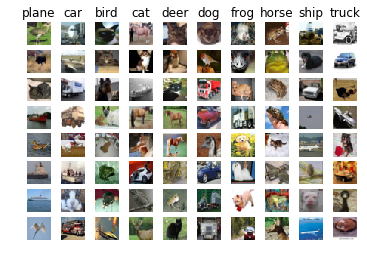

In [13]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

#### Answer:
For the plane classification, there are misclassifications where blue backgrounds were misclassified as plane. A bird flying in the sky is a prime example. Some of these just doesn't make sense. For example, a fire truck and a car is misclassified as a dog. A horse was misclassified as a deer, and I think that makes sense in terms of their general body structure and colors.


## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [15]:
print(X_train_feats_ns.shape)
print(X_train_feats_ns[1])

(49000, 154)
[  6.05423653e-01   1.85566697e-01  -1.13730959e-01  -1.60456260e-02
  -8.34658416e-02  -2.50621062e-01   1.27364141e+00   1.97535467e+00
  -4.02767356e-01  -7.41232652e-01  -1.96680186e-02  -3.40948969e-02
  -2.36230129e-01   3.28998903e-01   3.75925544e-02   1.37273094e+00
   3.59071478e+00   1.97713056e+00   6.65401507e-01   9.97953285e-01
  -8.05994680e-01   4.28571471e-01  -3.17905205e-03   1.01251442e+00
  -7.70527071e-01   3.73737774e-01   6.71181412e-01   6.48049086e+00
  -5.92421171e-01  -5.39060042e-01  -5.38002985e-01   1.91582894e-01
  -6.58222447e-01  -6.57190521e-01   2.69171709e-01   5.17183066e+00
   4.88780785e-01   3.58201590e+00   2.94600260e+00  -7.11785442e-01
   1.72701437e+00   1.82473716e-01   8.71822108e-02   4.84232754e+00
   3.30542361e+00  -8.63908585e-01  -9.24227672e-01  -7.02111206e-01
  -9.19568972e-04   2.79868003e-01   8.07778209e-01   3.99113127e-01
   1.55877745e+00   6.65597228e-01   3.26899593e+00  -5.19817502e-01
  -9.14409040e-01   6

In [5]:
from cs231n.classifiers.neural_net import TwoLayerNet
    
# input_dim = X_train_feats.shape[1]
# hidden_dim = 500
# num_classes = 10

# net = TwoLayerNet(input_dim, hidden_dim, num_classes)
# best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
def train(hidden_layer_unit_count,
          num_iters,
          learning_rate,
          regularization_strength,
          input_X_train,
          input_y_train,
          input_X_val,
          input_y_val,
          init_std,
          dropout=None):
    
    input_size = input_X_train.shape[1]
    num_classes = 10
    
    print(f'training with lr: {learning_rate}, reg: {regularization_strength}, and hidden: {hidden_layer_unit_count}')
    net = TwoLayerNet(input_size,
                      hidden_layer_unit_count,
                      num_classes,
                      std=init_std)
    # Train the network
    stats = net.train(input_X_train, input_y_train, input_X_val, input_y_val,
                      num_iters=num_iters,
                      batch_size=200,
                      learning_rate=learning_rate, 
                      learning_rate_decay=0.95,
                      reg=regularization_strength, 
                      verbose=True, 
                      dropout=dropout)
    return (net, stats)
    
def run_training_nn(hidden_layer_unit_counts,
                 regularization_strengths,
                 learning_rates,
                 epochs,
                 dropout,
                 input_X_train,
                 input_y_train,
                 input_X_val,
                 input_y_val,
                 init_std=1e-4):
    best_net = None # store the best model into this 
    best_stats = None
    best_val_acc = -1

    batch_size = 200
    num_iters_for_epoch = max(len(input_X_train) / batch_size, 1)
    num_iters = int(num_iters_for_epoch * epochs)
    results = {}

    for hidden_layer_unit_count in hidden_layer_unit_counts:
        for regularization_strength in regularization_strengths:
            for learning_rate in learning_rates:
                net, stats = train(hidden_layer_unit_count,
                                   num_iters,
                                   learning_rate,
                                   regularization_strength,
                                   input_X_train=input_X_train,
                                   input_y_train=input_y_train,
                                   input_X_val=input_X_val,
                                   input_y_val=input_y_val,
                                   init_std=init_std,
                                   dropout=dropout)
                val_acc = stats['val_acc_history'][-1]    
                if best_val_acc < val_acc:
                    best_val_acc = val_acc
                    best_net = net
                    best_stats = stats

                train_acc = stats['train_acc_history'][-1]

                print()
                print('in progress lr %e reg %e train accuracy: %f val accuracy: %f' % (
                    learning_rate, regularization_strength, train_acc, val_acc))
                print()
                results[(learning_rate, regularization_strength)] = (train_acc, val_acc)

    plt.subplot(2, 1, 1)
    plt.plot(best_stats['loss_history'])
    plt.title('Loss history')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')

    plt.subplot(2, 1, 2)
    plt.plot(best_stats['train_acc_history'], label='train')
    plt.plot(best_stats['val_acc_history'], label='val')
    plt.title('Classification accuracy history')
    plt.xlabel('Epoch')
    plt.ylabel('Classification accuracy')
    plt.show()

    print("best val acc:", best_val_acc)
    for lr, reg in sorted(results):
        train_accuracy, val_accuracy = results[(lr, reg)]
        print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                    lr, reg, train_accuracy, val_accuracy))
    return (best_net, best_stats, best_val_acc)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

[9.658381320333902e-06, 4.116736707680054e-05, 0.0007703412953605431]
[0.004800756346432544, 0.010809220665836238, 0.37762735391189883]
training with lr: 9.658381320333902e-06, reg: 0.004800756346432544, and hidden: 500
grads W1 mean 0.000439322290387
grads b1 mean 0.000374667871428
grads W2 mean 0.00163653448163
grads b2 mean 0.0109181799982
iteration 0 / 1225: loss 2.341980
grads W1 mean 0.000473821832048
grads b1 mean 0.000402167291238
grads W2 mean 0.00174844289541
grads b2 mean 0.00905978638926
iteration 50 / 1225: loss 2.341486
grads W1 mean 0.000447877253758
grads b1 mean 0.000491688679035
grads W2 mean 0.00177354475907
grads b2 mean 0.0215896654195
iteration 100 / 1225: loss 2.342132
grads W1 mean 0.000468764965398
grads b1 mean 0.000425400461376
grads W2 mean 0.00174912435466
grads b2 mean 0.0135149275048
iteration 150 / 1225: loss 2.340028
grads W1 mean 0.000473066609143
grads b1 mean 0.000476935870476
grads W2 mean 0.00189314926156
grads b2 mean 0.0218550685806
iteration 200

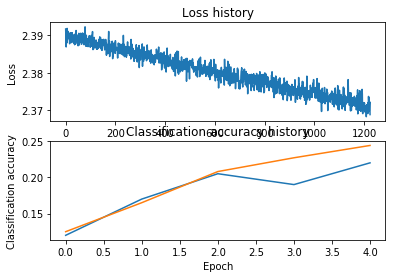

best val acc: 0.244
lr 9.658381e-06 reg 4.800756e-03 train accuracy: 0.105000 val accuracy: 0.119000
lr 9.658381e-06 reg 1.080922e-02 train accuracy: 0.070000 val accuracy: 0.094000
lr 9.658381e-06 reg 3.776274e-01 train accuracy: 0.095000 val accuracy: 0.107000
lr 4.116737e-05 reg 4.800756e-03 train accuracy: 0.145000 val accuracy: 0.146000
lr 4.116737e-05 reg 1.080922e-02 train accuracy: 0.060000 val accuracy: 0.086000
lr 4.116737e-05 reg 3.776274e-01 train accuracy: 0.110000 val accuracy: 0.114000
lr 7.703413e-04 reg 4.800756e-03 train accuracy: 0.215000 val accuracy: 0.236000
lr 7.703413e-04 reg 1.080922e-02 train accuracy: 0.220000 val accuracy: 0.244000
lr 7.703413e-04 reg 3.776274e-01 train accuracy: 0.220000 val accuracy: 0.209000


<IPython.core.display.Javascript object>

In [19]:
# Trial 1

learning_rates = []
for exponent in range(-6, -3):
    for _ in range(1):
        learning_rates.append(np.random.uniform(10**(exponent), 10**(exponent+1)))

regularization_strengths = []
for exponent in range(-3, 0):
    for _ in range(1):
        regularization_strengths.append(np.random.uniform(10**(exponent), 10**(exponent+1)))
        
hidden_layer_unit_counts = [500]
print(learning_rates)
print(regularization_strengths)
epochs = 5
dropout = None

best_net, best_stats, best_val_acc = run_training_nn(hidden_layer_unit_counts,
                                                     regularization_strengths,   
                                                     learning_rates,
                                                     epochs,   
                                                     dropout,
                                                     X_train_feats_ns,
                                                     y_train,
                                                     X_val_feats_ns,
                                                     y_val,
                                                     init_std=1e-2)
# End
%notify

[5.921109782043472e-05, 9.102571016344686e-05, 2.6935714038182868e-05, 0.0008673062248292653, 0.0008367837616075865, 0.0003275029093774102, 0.0010905761263275012, 0.004135675580883972, 0.009182667727792665]
[0.00013948243090723745, 0.00023444641851022487, 0.006392070989368892, 0.0030453720811728486, 0.05677773276646615, 0.023501299679046697]
training with lr: 5.921109782043472e-05, reg: 0.00013948243090723745, and hidden: 500
grads W1 mean 0.000445270643588
grads b1 mean 0.0004577635163
grads W2 mean 0.0018076380531
grads b2 mean 0.0153811174212
iteration 0 / 1225: loss 2.303908
grads W1 mean 0.000452482447896
grads b1 mean 0.000432830411524
grads W2 mean 0.00179061974467
grads b2 mean 0.0128110016247
iteration 50 / 1225: loss 2.303971
grads W1 mean 0.000423441680629
grads b1 mean 0.000397228531661
grads W2 mean 0.00177311749016
grads b2 mean 0.016213332453
iteration 100 / 1225: loss 2.305505
grads W1 mean 0.000422589962632
grads b1 mean 0.000477474699186
grads W2 mean 0.0019155182849


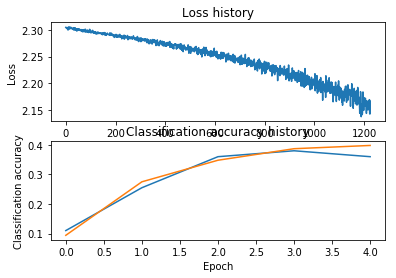

best val acc: 0.398
lr 2.693571e-05 reg 1.394824e-04 train accuracy: 0.150000 val accuracy: 0.115000
lr 2.693571e-05 reg 2.344464e-04 train accuracy: 0.100000 val accuracy: 0.095000
lr 2.693571e-05 reg 3.045372e-03 train accuracy: 0.140000 val accuracy: 0.149000
lr 2.693571e-05 reg 6.392071e-03 train accuracy: 0.065000 val accuracy: 0.110000
lr 2.693571e-05 reg 2.350130e-02 train accuracy: 0.125000 val accuracy: 0.098000
lr 2.693571e-05 reg 5.677773e-02 train accuracy: 0.145000 val accuracy: 0.101000
lr 5.921110e-05 reg 1.394824e-04 train accuracy: 0.085000 val accuracy: 0.093000
lr 5.921110e-05 reg 2.344464e-04 train accuracy: 0.120000 val accuracy: 0.109000
lr 5.921110e-05 reg 3.045372e-03 train accuracy: 0.105000 val accuracy: 0.123000
lr 5.921110e-05 reg 6.392071e-03 train accuracy: 0.065000 val accuracy: 0.106000
lr 5.921110e-05 reg 2.350130e-02 train accuracy: 0.090000 val accuracy: 0.090000
lr 5.921110e-05 reg 5.677773e-02 train accuracy: 0.150000 val accuracy: 0.129000
lr 9.102

<IPython.core.display.Javascript object>

In [20]:
# Trial 2

learning_rates = []
for exponent in range(-5, -2):
    for _ in range(3):
        learning_rates.append(np.random.uniform(10**(exponent), 10**(exponent+1)))

regularization_strengths = []
for exponent in range(-4, -1):
    for _ in range(2):
        regularization_strengths.append(np.random.uniform(10**(exponent), 10**(exponent+1)))
        
hidden_layer_unit_counts = [500]
print(learning_rates)
print(regularization_strengths)
epochs = 5
dropout = None

best_net, best_stats, best_val_acc = run_training_nn(hidden_layer_unit_counts,
                                                     regularization_strengths,   
                                                     learning_rates,
                                                     epochs,   
                                                     dropout,
                                                     X_train_feats_ns,
                                                     y_train,
                                                     X_val_feats_ns,
                                                     y_val,
                                                     init_std=1e-2)
# End
%notify

[0.009182668, 0.00525192029143174, 0.0016874097537214895, 0.0014780932436230518, 0.004281349161464919, 0.052221012423023606, 0.03489295083296056, 0.09810167152981045, 0.06819235836151254]
[0.0002344464, 6.412968157558411e-05, 6.033790301146037e-05, 0.0005051332334239847, 0.00024389209557720446, 0.00904901559196633, 0.009453225739362112]
training with lr: 0.009182668, reg: 0.0002344464, and hidden: 500
grads W1 mean 0.000481884486018
grads b1 mean 0.000430126572588
grads W2 mean 0.00195486885409
grads b2 mean 0.0129730836294
iteration 0 / 1225: loss 2.306425
grads W1 mean 0.000493590766041
grads b1 mean 0.000529012008494
grads W2 mean 0.00207649655453
grads b2 mean 0.0228944059037
iteration 50 / 1225: loss 2.294619
grads W1 mean 0.000485087077554
grads b1 mean 0.000492999006539
grads W2 mean 0.00201145944257
grads b2 mean 0.0170922704402
iteration 100 / 1225: loss 2.288642
grads W1 mean 0.00049933241603
grads b1 mean 0.000524810024788
grads W2 mean 0.00196312669241
grads b2 mean 0.01804

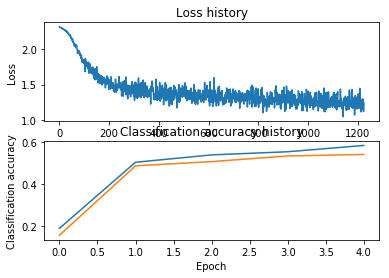

best val acc: 0.542
lr 1.478093e-03 reg 6.033790e-05 train accuracy: 0.230000 val accuracy: 0.289000
lr 1.478093e-03 reg 6.412968e-05 train accuracy: 0.330000 val accuracy: 0.310000
lr 1.478093e-03 reg 2.344464e-04 train accuracy: 0.265000 val accuracy: 0.286000
lr 1.478093e-03 reg 2.438921e-04 train accuracy: 0.245000 val accuracy: 0.292000
lr 1.478093e-03 reg 5.051332e-04 train accuracy: 0.255000 val accuracy: 0.290000
lr 1.478093e-03 reg 9.049016e-03 train accuracy: 0.300000 val accuracy: 0.326000
lr 1.478093e-03 reg 9.453226e-03 train accuracy: 0.235000 val accuracy: 0.265000
lr 1.687410e-03 reg 6.033790e-05 train accuracy: 0.335000 val accuracy: 0.313000
lr 1.687410e-03 reg 6.412968e-05 train accuracy: 0.320000 val accuracy: 0.339000
lr 1.687410e-03 reg 2.344464e-04 train accuracy: 0.240000 val accuracy: 0.282000
lr 1.687410e-03 reg 2.438921e-04 train accuracy: 0.305000 val accuracy: 0.295000
lr 1.687410e-03 reg 5.051332e-04 train accuracy: 0.255000 val accuracy: 0.316000
lr 1.687

<IPython.core.display.Javascript object>

In [22]:
# Trial 3

learning_rates = [9.182668e-03]
for exponent in range(-3, -1):
    for _ in range(4):
        learning_rates.append(np.random.uniform(10**(exponent), 10**(exponent+1)))

regularization_strengths = [2.344464e-04]
for exponent in range(-5, -2):
    for _ in range(2):
        regularization_strengths.append(np.random.uniform(10**(exponent), 10**(exponent+1)))
        
hidden_layer_unit_counts = [500]
print(learning_rates)
print(regularization_strengths)
epochs = 5
dropout = 0.8

best_net, best_stats, best_val_acc = run_training_nn(hidden_layer_unit_counts,
                                                     regularization_strengths,   
                                                     learning_rates,
                                                     epochs,   
                                                     dropout,
                                                     X_train_feats_ns,
                                                     y_train,
                                                     X_val_feats_ns,
                                                     y_val,
                                                     init_std=1e-2)
# End
%notify

[0.09810167, 0.008034961289800533, 0.03258623365777776, 0.16186450855242568]
[0.0002344464, 6.0490158414248026e-05, 7.932530881548366e-05, 0.0003828868319205216, 0.0005178222344067458]
training with lr: 0.09810167, reg: 0.0002344464, and hidden: 500
grads W1 mean 0.000478035387977
grads b1 mean 0.000454856189472
grads W2 mean 0.00184101861979
grads b2 mean 0.018135473713
iteration 0 / 2450: loss 2.307316
grads W1 mean 0.000716176386782
grads b1 mean 0.0014146568879
grads W2 mean 0.00260598651692
grads b2 mean 0.0133308512245
iteration 50 / 2450: loss 2.130149
grads W1 mean 0.000913159072923
grads b1 mean 0.00147834998604
grads W2 mean 0.00244259224272
grads b2 mean 0.0167009694003
iteration 100 / 2450: loss 1.854499
grads W1 mean 0.00111208383707
grads b1 mean 0.00144401271993
grads W2 mean 0.00262805795449
grads b2 mean 0.0143560426197
iteration 150 / 2450: loss 1.627120
grads W1 mean 0.00113949119202
grads b1 mean 0.00188081941836
grads W2 mean 0.00262497237813
grads b2 mean 0.016821

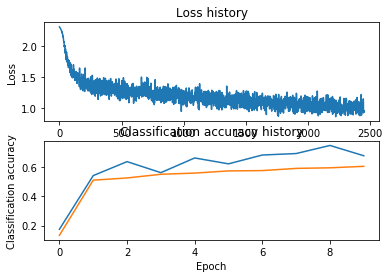

best val acc: 0.603
lr 8.034961e-03 reg 6.049016e-05 train accuracy: 0.465000 val accuracy: 0.432000
lr 8.034961e-03 reg 7.932531e-05 train accuracy: 0.395000 val accuracy: 0.439000
lr 8.034961e-03 reg 2.344464e-04 train accuracy: 0.405000 val accuracy: 0.437000
lr 8.034961e-03 reg 3.828868e-04 train accuracy: 0.430000 val accuracy: 0.429000
lr 8.034961e-03 reg 5.178222e-04 train accuracy: 0.420000 val accuracy: 0.431000
lr 3.258623e-02 reg 6.049016e-05 train accuracy: 0.575000 val accuracy: 0.519000
lr 3.258623e-02 reg 7.932531e-05 train accuracy: 0.530000 val accuracy: 0.521000
lr 3.258623e-02 reg 2.344464e-04 train accuracy: 0.525000 val accuracy: 0.525000
lr 3.258623e-02 reg 3.828868e-04 train accuracy: 0.555000 val accuracy: 0.527000
lr 3.258623e-02 reg 5.178222e-04 train accuracy: 0.595000 val accuracy: 0.518000
lr 9.810167e-02 reg 6.049016e-05 train accuracy: 0.635000 val accuracy: 0.579000
lr 9.810167e-02 reg 7.932531e-05 train accuracy: 0.665000 val accuracy: 0.577000
lr 9.810

<IPython.core.display.Javascript object>

In [25]:
# Trial 4

learning_rates = [9.810167e-02]
for exponent in range(-3, 0):
    for _ in range(1):
        learning_rates.append(np.random.uniform(10**(exponent), 10**(exponent+1)))

regularization_strengths = [2.344464e-04]
for exponent in range(-5, -3):
    for _ in range(2):
        regularization_strengths.append(np.random.uniform(10**(exponent), 10**(exponent+1)))
        
hidden_layer_unit_counts = [500]
print(learning_rates)
print(regularization_strengths)
epochs = 10
dropout = 0.95

best_net, best_stats, best_val_acc = run_training_nn(hidden_layer_unit_counts,
                                                     regularization_strengths,   
                                                     learning_rates,
                                                     epochs,   
                                                     dropout,
                                                     X_train_feats_ns,
                                                     y_train,
                                                     X_val_feats_ns,
                                                     y_val,
                                                     init_std=1e-2)
# End
%notify

# lr 9.810167e-02 reg 2.344464e-04 train accuracy: 0.585000 val accuracy: 0.542000
# lr 9.810167e-02 reg 2.438921e-04 train accuracy: 0.590000 val accuracy: 0.542000

[0.1618645, 0.07446166150111383, 0.19015692526028338, 4.066575202042193]
[7.932531e-05, 0.0002344464, 0.0003828868, 7.35861112241777e-05, 0.0006057308188910892]
training with lr: 0.1618645, reg: 7.932531e-05, and hidden: 500
grads W1 mean 0.000450349211232
grads b1 mean 0.000546023157482
grads W2 mean 0.0020083790723
grads b2 mean 0.0249911078931
iteration 0 / 3675: loss 2.305969
grads W1 mean 0.000886032307813
grads b1 mean 0.00182564603214
grads W2 mean 0.00291245492539
grads b2 mean 0.0156985626763
iteration 50 / 3675: loss 1.884229
grads W1 mean 0.0012634717451
grads b1 mean 0.0018704668635
grads W2 mean 0.00320480111157
grads b2 mean 0.0163669879544
iteration 100 / 3675: loss 1.580024
grads W1 mean 0.00135381975546
grads b1 mean 0.00133319869894
grads W2 mean 0.00282437977065
grads b2 mean 0.013970847925
iteration 150 / 3675: loss 1.465697
grads W1 mean 0.00148672446524
grads b1 mean 0.00153367368668
grads W2 mean 0.00285187504008
grads b2 mean 0.0133885184635
iteration 200 / 3675

/Users/jin/workspace/learning/stanford/cs231n/assignments/assignment1/cs231n/classifiers/neural_net.py:110: RuntimeWarning: divide by zero encountered in log
  losses = -np.log(exp_ratios)
/Users/jin/workspace/learning/stanford/cs231n/assignments/assignment1/cs231n/classifiers/neural_net.py:131: RuntimeWarning: divide by zero encountered in true_divide
  grad_ln = 1 / exp_ratios
/Users/jin/workspace/learning/stanford/cs231n/assignments/assignment1/cs231n/classifiers/neural_net.py:143: RuntimeWarning: invalid value encountered in multiply
  dExpPreDot = dln * grad_label_exps_multiply * grad_exp
/Users/jin/workspace/learning/stanford/cs231n/assignments/assignment1/cs231n/classifiers/neural_net.py:155: RuntimeWarning: invalid value encountered in multiply
  dSum = dln * grad_label_exps_multiply * grad_flip
/Users/jin/workspace/learning/stanford/cs231n/assignments/assignment1/cs231n/classifiers/neural_net.py:86: RuntimeWarning: invalid value encountered in greater
  activated_logits = hidd

grads W1 mean nan
grads b1 mean nan
grads W2 mean nan
grads b2 mean nan
iteration 50 / 3675: loss nan
grads W1 mean nan
grads b1 mean nan
grads W2 mean nan
grads b2 mean nan
iteration 100 / 3675: loss nan
grads W1 mean nan
grads b1 mean nan
grads W2 mean nan
grads b2 mean nan
iteration 150 / 3675: loss nan
grads W1 mean nan
grads b1 mean nan
grads W2 mean nan
grads b2 mean nan
iteration 200 / 3675: loss nan
grads W1 mean nan
grads b1 mean nan
grads W2 mean nan
grads b2 mean nan
iteration 250 / 3675: loss nan
grads W1 mean nan
grads b1 mean nan
grads W2 mean nan
grads b2 mean nan
iteration 300 / 3675: loss nan
grads W1 mean nan
grads b1 mean nan
grads W2 mean nan
grads b2 mean nan
iteration 350 / 3675: loss nan
grads W1 mean nan
grads b1 mean nan
grads W2 mean nan
grads b2 mean nan
iteration 400 / 3675: loss nan
grads W1 mean nan
grads b1 mean nan
grads W2 mean nan
grads b2 mean nan
iteration 450 / 3675: loss nan
grads W1 mean nan
grads b1 mean nan
grads W2 mean nan
grads b2 mean nan
it

/Users/jin/workspace/learning/stanford/cs231n/assignments/assignment1/cs231n/classifiers/neural_net.py:131: RuntimeWarning: overflow encountered in true_divide
  grad_ln = 1 / exp_ratios
/Users/jin/workspace/learning/stanford/cs231n/assignments/assignment1/cs231n/classifiers/neural_net.py:156: RuntimeWarning: invalid value encountered in multiply
  return grad_exp * np.expand_dims(dSum, 1)
/Users/jin/workspace/learning/stanford/cs231n/assignments/assignment1/cs231n/classifiers/neural_net.py:160: RuntimeWarning: invalid value encountered in add
  dSumW1b1 = denominator_dExp + numerator_dExp


grads W1 mean nan
grads b1 mean nan
grads W2 mean nan
grads b2 mean nan
iteration 50 / 3675: loss nan
grads W1 mean nan
grads b1 mean nan
grads W2 mean nan
grads b2 mean nan
iteration 100 / 3675: loss nan
grads W1 mean nan
grads b1 mean nan
grads W2 mean nan
grads b2 mean nan
iteration 150 / 3675: loss nan
grads W1 mean nan
grads b1 mean nan
grads W2 mean nan
grads b2 mean nan
iteration 200 / 3675: loss nan
grads W1 mean nan
grads b1 mean nan
grads W2 mean nan
grads b2 mean nan
iteration 250 / 3675: loss nan
grads W1 mean nan
grads b1 mean nan
grads W2 mean nan
grads b2 mean nan
iteration 300 / 3675: loss nan
grads W1 mean nan
grads b1 mean nan
grads W2 mean nan
grads b2 mean nan
iteration 350 / 3675: loss nan
grads W1 mean nan
grads b1 mean nan
grads W2 mean nan
grads b2 mean nan
iteration 400 / 3675: loss nan
grads W1 mean nan
grads b1 mean nan
grads W2 mean nan
grads b2 mean nan
iteration 450 / 3675: loss nan
grads W1 mean nan
grads b1 mean nan
grads W2 mean nan
grads b2 mean nan
it

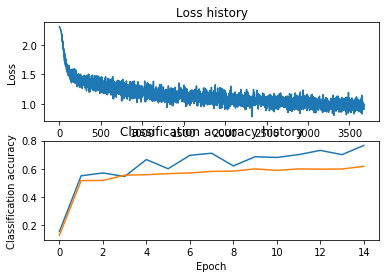

best val acc: 0.617
lr 7.446166e-02 reg 7.358611e-05 train accuracy: 0.685000 val accuracy: 0.569000
lr 7.446166e-02 reg 7.932531e-05 train accuracy: 0.695000 val accuracy: 0.587000
lr 7.446166e-02 reg 2.344464e-04 train accuracy: 0.625000 val accuracy: 0.585000
lr 7.446166e-02 reg 3.828868e-04 train accuracy: 0.645000 val accuracy: 0.589000
lr 7.446166e-02 reg 6.057308e-04 train accuracy: 0.635000 val accuracy: 0.576000
lr 1.618645e-01 reg 7.358611e-05 train accuracy: 0.775000 val accuracy: 0.614000
lr 1.618645e-01 reg 7.932531e-05 train accuracy: 0.755000 val accuracy: 0.598000
lr 1.618645e-01 reg 2.344464e-04 train accuracy: 0.715000 val accuracy: 0.599000
lr 1.618645e-01 reg 3.828868e-04 train accuracy: 0.765000 val accuracy: 0.617000
lr 1.618645e-01 reg 6.057308e-04 train accuracy: 0.715000 val accuracy: 0.608000
lr 1.901569e-01 reg 7.358611e-05 train accuracy: 0.755000 val accuracy: 0.609000
lr 1.901569e-01 reg 7.932531e-05 train accuracy: 0.845000 val accuracy: 0.590000
lr 1.901

<IPython.core.display.Javascript object>

In [6]:
# Trial 5

learning_rates = [1.618645e-01]
for exponent in range(-2, 1):
    for _ in range(1):
        learning_rates.append(np.random.uniform(10**(exponent), 10**(exponent+1)))

regularization_strengths = [7.932531e-05, 
                            2.344464e-04,
                            3.828868e-04]
for exponent in range(-5, -3):
    for _ in range(1):
        regularization_strengths.append(np.random.uniform(10**(exponent), 10**(exponent+1)))
        
hidden_layer_unit_counts = [500]
print(learning_rates)
print(regularization_strengths)
epochs = 15
dropout = 0.95

best_net, best_stats, best_val_acc = run_training_nn(hidden_layer_unit_counts,
                                                     regularization_strengths,   
                                                     learning_rates,
                                                     epochs,   
                                                     dropout,
                                                     X_train_feats_ns,
                                                     y_train,
                                                     X_val_feats_ns,
                                                     y_val,
                                                     init_std=1e-2)
# End
%notify
# lr 1.618645e-01 reg 7.932531e-05 train accuracy: 0.745000 val accuracy: 0.602000
# lr 1.618645e-01 reg 2.344464e-04 train accuracy: 0.675000 val accuracy: 0.603000
# lr 1.618645e-01 reg 3.828868e-04 train accuracy: 0.720000 val accuracy: 0.601000


In [7]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats_ns) == y_test).mean()
print(test_acc)

0.572


# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!